# voxTrace Interface

To create an environment use:

        conda create --name vt python=3 xraylib=4.1.3 jupyter ipykernel matplotlib h5py pandas -c conda-forge

        conda activate vt

### Imports

In [1]:
import os
import numpy as np
import h5py as h5p
import xraylib as xrl
import pandas as pd
from matplotlib import pyplot as plt

### Helper Functions

In [2]:
def get_file_number(filename, start, end):
    number = filename[start:end].strip('()')
    number = int(float(number))
    return number

### Simulated Data

In [3]:
#filename = "/media/miro/Data-1TB/nist-1107-simulation/nist-1107-pos-(15.000000).h5"
# get number out of filename /media/miro/Data-1TB/nist-1107-simulation/nist-1107-pos-(NUMBER).h5
# get number out of filename /media/miro/Data-1TB/nist-1107-simulation/post-sample/nist-1107-pos-(-135.000000).h5

# find files in directory
directory = "/media/miro/Data-1TB/nist-1107-simulation/post-sample-12/"
directory_2 = "/media/miro/Data-1TB/nist-1107-simulation/detector-12/"

files = [os.path.join(directory, file) for file in os.listdir(directory)]
files_2 = [os.path.join(directory_2, file) for file in os.listdir(directory_2)]

files.sort(key=lambda x: get_file_number(x, 71, -3))        # #key=get_file_number
files_2.sort(key=lambda x: get_file_number(x, 69, -12))

#print(files)
#print(files_2)

n_files = len(files)

energies = []
respawns = []
respawns_sum = []

energies_2 = []
probs_2 = []
probs_2_sum = []

for i in range(n_files):
    energies.append(h5p.File(files[i], 'r')['my_data'][10] / 50677300.0)
    respawns.append(h5p.File(files[i], 'r')['my_data'][20])
    respawns_sum.append(h5p.File(files[i], 'r')['my_data'][20].sum())

    energies_2.append(h5p.File(files_2[i], 'r')['my_data'][10] / 50677300.0)
    probs_2.append(h5p.File(files_2[i], 'r')['my_data'][18])
    probs_2_sum.append(h5p.File(files_2[i], 'r')['my_data'][18].sum())

energies_respawns = []
energies_probs = []

for i in range(n_files):
    energies_respawns.append(np.array([energies[i], respawns[i]]).transpose())
    energies_probs.append(np.array([energies_2[i], probs_2[i]]).transpose())

# Define the number of bins and the range of energies
my_bins = 2048
my_range = (-0.1718, 22.6634)

# Create the bin edges
bin_edges = np.linspace(start=my_range[0], stop=my_range[1], num=my_bins+1)

In [4]:
post_sample_energy_hists = []
post_sample_respawn_hists = []

detector_energy_hists = []
detector_prob_hists = []

for i in range(n_files):
    energy_respawn = energies_respawns[i]
    energy, respawn = zip(*energy_respawn)

    histograms_1 = np.zeros(my_bins)
    histograms_2 = np.zeros(my_bins)

    post_sample_energy_hists.append(np.zeros(my_bins))
    post_sample_respawn_hists.append(np.zeros(my_bins))

    detector_energy_hists.append(np.zeros(my_bins))
    detector_prob_hists.append(np.zeros(my_bins))

    for energy, respawn in energy_respawn:
        bin_index = np.digitize([energy], bin_edges)[0] - 1
        post_sample_energy_hists[i][bin_index] += 1
        post_sample_respawn_hists[i][bin_index] += respawn

    en_prob = energies_probs[i]
    en, prob = zip(*en_prob)

    for en, prob in en_prob:
        bin_index = np.digitize([en], bin_edges)[0] - 1
        detector_energy_hists[i][bin_index] += 1
        detector_prob_hists[i][bin_index] += prob

In [5]:
histogramm_list = []
cu = []
zn = []
tot = []

cu_2 = []
zn_2 = []
tot_2 = []

cu_respawn = []
zn_respawn = []
tot_respawn = []

cu_prob = []
zn_prob = []
tot_prob = []

cu_faltung = []
zn_faltung = []
tot_faltung = []

ps_ratio = []

for i in range(0, n_files):
    # Make a HistogrammList of energies[1] with 2048 bins and a bin width of 0.01115 and an offset of -0.1718 and store it as array
    #histogramm = np.histogram(energies_2[i], bins=2048, range=(-0.1718, 22.6634))
    #histogramm_list.append(histogramm)

    # make sum of channels [708,755] and [756,803] and store it as array
    cu.append(np.sum(post_sample_energy_hists[i][708:755])) #/respawns[i] *6000000.
    zn.append(np.sum(post_sample_energy_hists[i][756:803])) #/respawns[i] *6000000.
    tot.append(np.sum(post_sample_energy_hists[i][0:2048])) #/respawns[i]
    #zn.append(np.sum(histogramm[0][756:803])/respawns_sum[i]) #/respawns[i] *6000000.
    #tot.append(np.sum(histogramm[0][0:2048])/respawns_sum[i]) #/respawns[i]

    cu_respawn.append(np.sum(post_sample_respawn_hists[i][708:755]))
    zn_respawn.append(np.sum(post_sample_respawn_hists[i][756:803]))
    tot_respawn.append(np.sum(post_sample_respawn_hists[i][0:2048]))

    cu_prob.append(np.sum(detector_prob_hists[i][708:755]))#/np.sum(detector_energy_hists[i][708:755])
    zn_prob.append(np.sum(detector_prob_hists[i][756:803]))#/np.sum(detector_energy_hists[i][756:803])
    tot_prob.append(np.sum(detector_prob_hists[i][0:2048]))#/np.sum(detector_energy_hists[i][0:2048])

    cu_faltung.append(np.sum(detector_energy_hists[i][708:755])/np.sum(post_sample_respawn_hists[i][0:2048])*30000000.)
    zn_faltung.append(np.sum(detector_energy_hists[i][756:803])/np.sum(post_sample_respawn_hists[i][0:2048])*30000000.)
    tot_faltung.append(np.sum(detector_energy_hists[i][0:2048])/np.sum(post_sample_respawn_hists[i][0:2048]))

    cu_2.append(np.sum(detector_energy_hists[i][708:755]))#*np.exp(-(i-20)*0.1)*10e6
    zn_2.append(np.sum(detector_energy_hists[i][756:803]))
    tot_2.append(np.sum(detector_energy_hists[i][0:2048]))
    
    ps_ratio.append(cu_2[i]/cu[i])

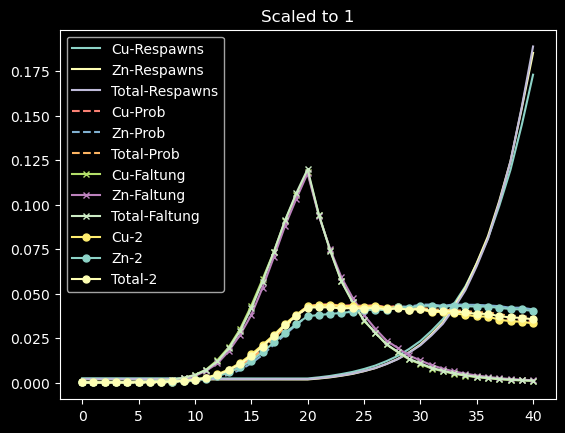

In [6]:
# plot ps_ratio
# plt.plot(ps_ratio)

# plot cu_respawn and zn_respawn and tot_respawn and tot_respawn_2 scaled to 1
plt.plot(cu_respawn/np.sum(cu_respawn), label='Cu-Respawns')
plt.plot(zn_respawn/np.sum(zn_respawn), label='Zn-Respawns')
plt.plot(tot_respawn/np.sum(tot_respawn), label='Total-Respawns')

# plot cu_prob and zn_prob and tot_prob scaled to 1
plt.plot(cu_prob/np.sum(cu_prob), label='Cu-Prob',linestyle='--')
plt.plot(zn_prob/np.sum(zn_prob), label='Zn-Prob',linestyle='--')
plt.plot(tot_prob/np.sum(tot_prob), label='Total-Prob',linestyle='--')

# plot cu_faltung and zn_faltung and tot_faltung scaled to 1
plt.plot(cu_faltung/np.sum(cu_faltung), label='Cu-Faltung', marker='x', markersize=5)
plt.plot(zn_faltung/np.sum(zn_faltung), label='Zn-Faltung', marker='x', markersize=5)
plt.plot(tot_faltung/np.sum(tot_faltung), label='Total-Faltung', marker='x', markersize=5)

# plot cu_2 and zn_2 and tot_2 scaled to 1
plt.plot(cu_2/np.sum(cu_2), label='Cu-2', marker='o', markersize=5)
plt.plot(zn_2/np.sum(zn_2), label='Zn-2', marker='o', markersize=5)
plt.plot(tot_2/np.sum(tot_2), label='Total-2', marker='o', markersize=5)


plt.legend()
plt.title('Scaled to 1')
plt.show()

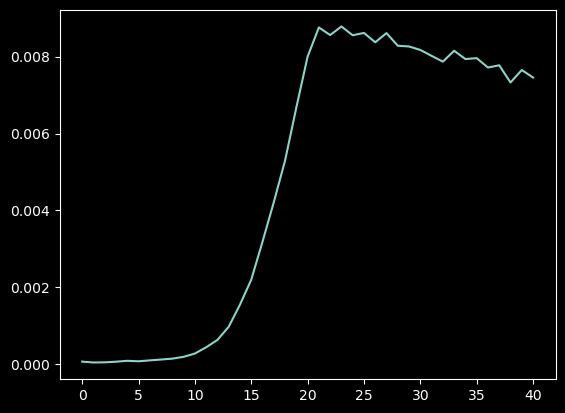

In [359]:
#plot ps_ratio
plt.plot(ps_ratio)

In [329]:
np.sum(detector_prob_hists[2][708:755])

24.16429965684877

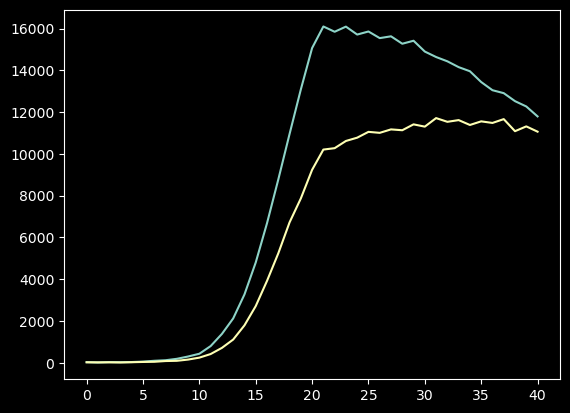

In [7]:
#plot cu_faltung and zn_faltung
plt.plot(cu_2, label='Cu')
plt.plot(zn_2, label='Zn')

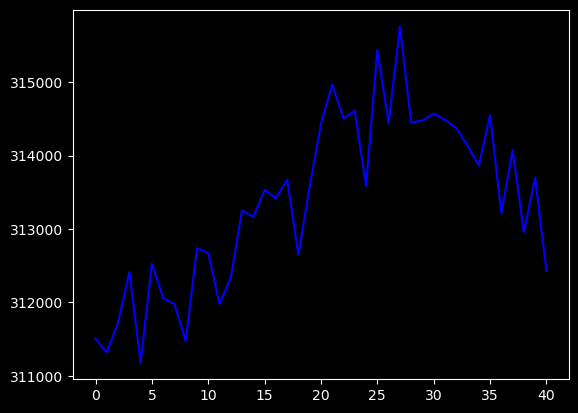

In [363]:
#plt.plot(cu, label='cu', color='green')
#plt.plot(cu_2, label='cu_2', color='red', linestyle='dashed')
plt.plot(zn, label='zn', color='blue')
#plt.plot(zn_2, label='zn_2', color='orange', linestyle='dashed')

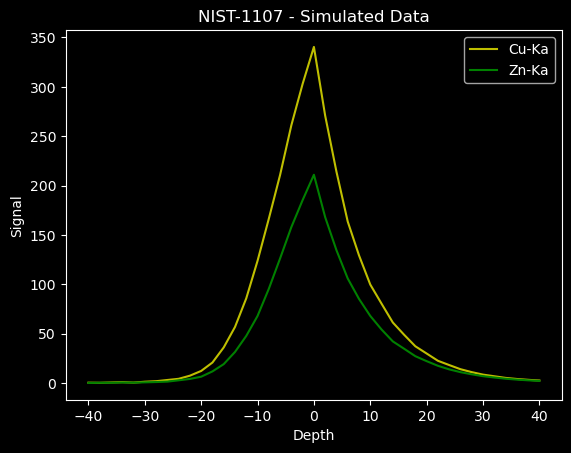

In [7]:
# create list with int entries from 0 to n_files-1 
myrange1 = [i*2-40 for i in range(n_files)]

plt.ylabel("Signal")
plt.xlabel("Depth")
plt.plot(myrange1, cu_faltung,'y',label='Cu-Ka')
plt.plot(myrange1, zn_faltung,'g',label='Zn-Ka')
plt.legend()
plt.title('NIST-1107 - Simulated Data')
plt.show()

### Measurement Data

In [8]:
file_loc_1 = '/media/miro/Data-1TB/nist-1107-measurement/nist-1107-depth-00-00/nist-1107-depth-00-00.txt'
file_loc_2 = '/media/miro/Data-1TB/nist-1107-measurement/nist-1107-depth-00-01/nist-1107-depth-00-01.txt'
file_loc_3 = '/media/miro/Data-1TB/nist-1107-measurement/nist-1107-depth-01-00/nist-1107-depth-01-00.txt'

# Read the file into a pandas dataframe
df_1 = pd.read_csv(file_loc_1, sep='\t', skiprows=7, header=None, names=["Motor-samplexraw", "Motor-sampleyraw", "Motor-samplex", "Motor-sampley", "Motor-samplez", "Motor-cap1x", "Motor-cap1y", "Motor-cap1z", "Motor-cap1yaw", "Motor-cap1pitch", "Motor-detectorx", "Motor-detectory", "Motor-detectorz", "Motor-mic", "Motor-th", "Motor-ml", "px5.Mo-Ka-Gro[1554,1628]", "px5.Mo-Ka-Net[1554,1628]", "px5.Ni-Ka-Gro[670,695]", "px5.Ni-Ka-Net[670,695]", "px5.Cu-Ka-Gro[708,755]", "px5.Cu-Ka-Net[708,755]", "px5.Fe-Ka-Gro[575,595]", "px5.Fe-Ka-Net[575,595]", "px5.Zn-Ka-Gro[770,800]", "px5.Zn-Ka-Net[770,800]", "px5.Sn-L-Gro[306,350]", "px5.Sn-L-Net[306,350]", "px5.Pb-L-Gro[1107,1173]", "px5.Pb-L-Net[1107,1173]", "px5.Realtime", "px5.Livetime", "px5.Deadtime", "px5.icr", "px5.ocr", "miccam.AvgR", "miccam.AvgG", "miccam.AvgB", "tube.Voltage", "tube.Current", "px5.Filename"])
df_2 = pd.read_csv(file_loc_2, sep='\t', skiprows=7, header=None, names=["Motor-samplexraw", "Motor-sampleyraw", "Motor-samplex", "Motor-sampley", "Motor-samplez", "Motor-cap1x", "Motor-cap1y", "Motor-cap1z", "Motor-cap1yaw", "Motor-cap1pitch", "Motor-detectorx", "Motor-detectory", "Motor-detectorz", "Motor-mic", "Motor-th", "Motor-ml", "px5.Mo-Ka-Gro[1554,1628]", "px5.Mo-Ka-Net[1554,1628]", "px5.Ni-Ka-Gro[670,695]", "px5.Ni-Ka-Net[670,695]", "px5.Cu-Ka-Gro[708,755]", "px5.Cu-Ka-Net[708,755]", "px5.Fe-Ka-Gro[575,595]", "px5.Fe-Ka-Net[575,595]", "px5.Zn-Ka-Gro[770,800]", "px5.Zn-Ka-Net[770,800]", "px5.Sn-L-Gro[306,350]", "px5.Sn-L-Net[306,350]", "px5.Pb-L-Gro[1107,1173]", "px5.Pb-L-Net[1107,1173]", "px5.Realtime", "px5.Livetime", "px5.Deadtime", "px5.icr", "px5.ocr", "miccam.AvgR", "miccam.AvgG", "miccam.AvgB", "tube.Voltage", "tube.Current", "px5.Filename"])
df_3 = pd.read_csv(file_loc_3, sep='\t', skiprows=7, header=None, names=["Motor-samplexraw", "Motor-sampleyraw", "Motor-samplex", "Motor-sampley", "Motor-samplez", "Motor-cap1x", "Motor-cap1y", "Motor-cap1z", "Motor-cap1yaw", "Motor-cap1pitch", "Motor-detectorx", "Motor-detectory", "Motor-detectorz", "Motor-mic", "Motor-th", "Motor-ml", "px5.Mo-Ka-Gro[1554,1628]", "px5.Mo-Ka-Net[1554,1628]", "px5.Ni-Ka-Gro[670,695]", "px5.Ni-Ka-Net[670,695]", "px5.Cu-Ka-Gro[708,755]", "px5.Cu-Ka-Net[708,755]", "px5.Fe-Ka-Gro[575,595]", "px5.Fe-Ka-Net[575,595]", "px5.Zn-Ka-Gro[770,800]", "px5.Zn-Ka-Net[770,800]", "px5.Sn-L-Gro[306,350]", "px5.Sn-L-Net[306,350]", "px5.Pb-L-Gro[1107,1173]", "px5.Pb-L-Net[1107,1173]", "px5.Realtime", "px5.Livetime", "px5.Deadtime", "px5.icr", "px5.ocr", "miccam.AvgR", "miccam.AvgG", "miccam.AvgB", "tube.Voltage", "tube.Current", "px5.Filename"])

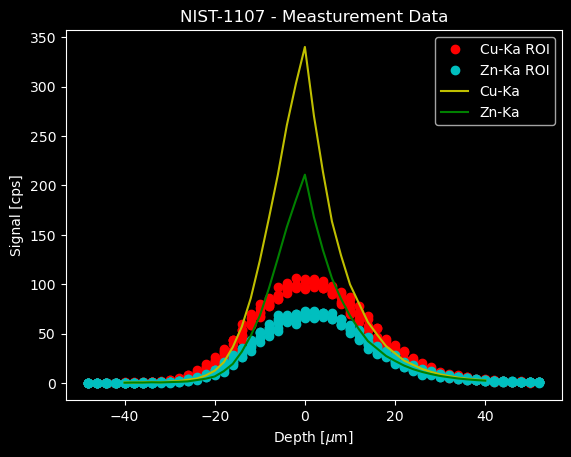

In [9]:
# find position of maximum signal df_3["px5.Cu-Ka-Gro[708,755]"]
max_pos = df_3["px5.Cu-Ka-Gro[708,755]"].idxmax()
max_corr= df_3["Motor-samplex"][max_pos]+2

# Plot the data
plt.ylabel("Signal [cps]")
plt.xlabel("Depth [$\mu$m]")
plt.plot(df_3["Motor-samplex"]-max_corr,df_3["px5.Cu-Ka-Gro[708,755]"]/df_3["px5.Livetime"],'ro',label='Cu-Ka ROI')
plt.plot(df_3["Motor-samplex"]-max_corr,df_3["px5.Zn-Ka-Gro[770,800]"]/df_3["px5.Livetime"],'co',label='Zn-Ka ROI')
plt.plot(myrange1, cu_faltung,'y',label='Cu-Ka')
plt.plot(myrange1, zn_faltung,'g',label='Zn-Ka')
plt.legend()
plt.title('NIST-1107 - Measturement Data')
plt.show()

In [15]:

myList2 = df_3["px5.Cu-Ka-Gro[708,755]"].tolist() 
mylist3= df_3["px5.Zn-Ka-Gro[770,800]"].tolist()
#divide each element of mylist2 by the corresponding element of mylist3
mylist4 = [x / (y+1) for x, y in zip(myList2, mylist3)]

In [16]:
# new list with each element of cu_faltung divided by the corresponding element of zn_faltung
mylist = [x/y for x, y in zip(cu_faltung, zn_faltung)]

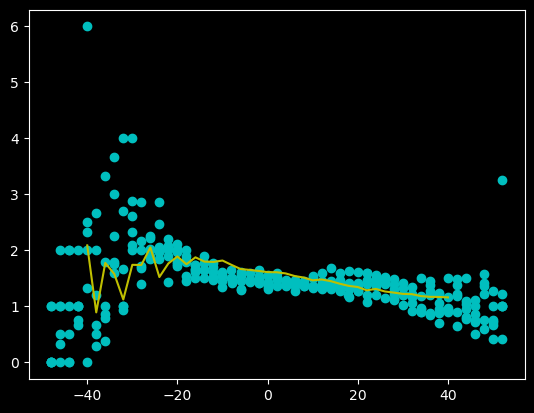

In [23]:
plt.plot(df_3["Motor-samplex"]-max_corr,mylist4,'co',label='Cu-Ka')
plt.plot(myrange1, mylist,'y',label='Cu-Ka')

#plt.plot(myrange1, zn_faltung,'g',label='Zn-Ka')

In [ ]:
#aaa=[df_3["Motor-samplex"]-max_corr,df_3["px5.Cu-Ka-Gro[708,755]"]/df_3["px5.Livetime"]]
#len(aaa[1])

In [ ]:
#f = h5py.File(filename, 'r')

#for key in f.keys():
#    print(key) #Names of the root level object names in HDF5 file - can be groups or datasets.
#    print(type(f[key])) # get the object type: usually group or dataset


#			rays[i].getStartX(),rays[i].getStartY(),rays[i].getStartZ(),
#			rays[i].getDirX(),rays[i].getDirY(),rays[i].getDirZ(),
#			rays[i].getSPolX(),rays[i].getSPolY(),rays[i].getSPolZ(),
#			(double) rays[i].getFlag(), rays[i].getWaveNumber(),(double) rays[i].getIndex(),
#			rays[i].getOpticalPath(),rays[i].getSPhase(),rays[i].getPPhase(),
#			rays[i].getPPolX(), rays[i].getPPolY(),rays[i].getPPolZ(),
#			rays[i].getProb(), (double) rays[i].getIANum(),(double) rays[i].getRespawnCounter()});  

#data = h5p.File(filename, 'r')['my_data']

#x_0 = data[0] 
#y_0 = data[1] 
#z_0 = data[2]

#x_1 = data[3]
#y_1 = data[4]
#z_1 = data[5]

#as_X = data[6]
#as_Y = data[7]
#as_Z = data[8]

#flag = data[9]
#wave_num = data[10]
#energies = data[10] / 50677300.0
#index = data[11]

#opd = data[12]
#s_Ph = data[13]
#p_Ph = data[14]

#ap_X = data[15]
#ap_Y = data[16]
#ap_Z = data[17]

#prob = data[18]
#ia_num = data[19]
#respawns = data[20]

#print(len(data))

#energies

#data[0][0]

#a_group_key = list(f.keys())[0]
#a_group_key
#data = group[some_key_inside_the_group][()]
#in(energies)
#max(energies)

### Call the code

In [ ]:
os.popen('./build/bin/Test-3').read()